In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import psutil

In [2]:
print(os.listdir('E:\\kaggle\\Avito Demand Prediction Challenge\\dataset\\'))

['avito_region_city_features.csv', 'city_population_wiki_v3.csv', 'periods_test.csv', 'periods_train.csv', 'region.csv', 'test.csv', 'test_active.csv', 'train.csv', 'train_active.csv']


In [3]:
dirpath='E:\\kaggle\\Avito Demand Prediction Challenge\\dataset\\'
train_df = pd.read_csv(dirpath+"train.csv", parse_dates=["activation_date"])

In [4]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [10]:
# date time features
train_df['weekday'] = train_df.activation_date.dt.weekday
train_df['month'] = train_df.activation_date.dt.month
train_df['day'] = train_df.activation_date.dt.day
train_df['week'] = train_df.activation_date.dt.week 

# length of description
train_df['description'] = train_df['description'].fillna(" ")
train_df['description_len'] = train_df['description'].apply(lambda x : len(x.split()))

# length of title
train_df['title'] = train_df['title'].fillna(" ")
train_df['title_len'] = train_df['title'].apply(lambda x : len(x.split()))

# param_combined and its length
train_df['param_combined'] = train_df.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']),  str(row['param_3'])]), axis=1)
train_df['param_combined'] = train_df['param_combined'].fillna(" ")
train_df['param_combined_len'] = train_df['param_combined'].apply(lambda x : len(x.split()))

# charater len of text columns
train_df['description_char'] = train_df['description'].apply(len)
train_df['title_char'] = train_df['title'].apply(len)
train_df['param_char'] = train_df['param_combined'].apply(len)

# english mapped of weekday
daymap = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
train_df['weekday_en'] = train_df['weekday'].apply(lambda x : daymap[x])

# bins of deal probability
interval = (-0.99, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1.1)
cats = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9','0.9-1.0']
train_df['deal_class'] = train_df['deal_probability'].apply(lambda x: ">=0.5" if x >=0.5 else "<0.5")
train_df["deal_class_2"] = pd.cut(train_df.deal_probability, interval, labels=cats)

In [11]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_len,title_len,param_combined,param_combined_len,description_char,title_char,param_char,weekday_en,deal_class,deal_class_2
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,7,3,Постельные принадлежности nan nan,4,58,21,33,Mon,<0.5,0.1-0.2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,7,3,Другое nan nan,3,41,17,14,Sat,<0.5,0-0.1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,17,2,"Видео, DVD и Blu-ray плееры nan nan",7,99,14,35,Sun,<0.5,0.4-0.5
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,3,1,Автомобильные кресла nan nan,4,22,10,28,Fri,>=0.5,0.8-0.9
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,4,3,С пробегом ВАЗ (LADA) 2110,5,24,14,26,Wed,<0.5,0.2-0.3





Translating few key columns in the dataset from russian to english language. These ready to use dictionaries are prepared using yandex. 

In [12]:
parent_category_name_map = {"Личные вещи" : "Personal belongings",
                            "Для дома и дачи" : "For the home and garden",
                            "Бытовая электроника" : "Consumer electronics",
                            "Недвижимость" : "Real estate",
                            "Хобби и отдых" : "Hobbies & leisure",
                            "Транспорт" : "Transport",
                            "Услуги" : "Services",
                            "Животные" : "Animals",
                            "Для бизнеса" : "For business"}

region_map = {"Свердловская область" : "Sverdlovsk oblast",
            "Самарская область" : "Samara oblast",
            "Ростовская область" : "Rostov oblast",
            "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",
            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",
            "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug",
            "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",
            "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",
            "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",
            "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",
            "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",
            "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",
            "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",
            "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",
            "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",
            "Тульская область" : "Tula oblast"}


category_map = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories",
"Детская одежда и обувь":"Children's clothing and shoes",
"Товары для детей и игрушки":"Children's products and toys",
"Квартиры":"Apartments",
"Телефоны":"Phones",
"Мебель и интерьер":"Furniture and interior",
"Предложение услуг":"Offer services",
"Автомобили":"Cars",
"Ремонт и строительство":"Repair and construction",
"Бытовая техника":"Appliances",
"Товары для компьютера":"Products for computer",
"Дома, дачи, коттеджи":"Houses, villas, cottages",
"Красота и здоровье":"Health and beauty",
"Аудио и видео":"Audio and video",
"Спорт и отдых":"Sports and recreation",
"Коллекционирование":"Collecting",
"Оборудование для бизнеса":"Equipment for business",
"Земельные участки":"Land",
"Часы и украшения":"Watches and jewelry",
"Книги и журналы":"Books and magazines",
"Собаки":"Dogs",
"Игры, приставки и программы":"Games, consoles and software",
"Другие животные":"Other animals",
"Велосипеды":"Bikes",
"Ноутбуки":"Laptops",
"Кошки":"Cats",
"Грузовики и спецтехника":"Trucks and buses",
"Посуда и товары для кухни":"Tableware and goods for kitchen",
"Растения":"Plants",
"Планшеты и электронные книги":"Tablets and e-books",
"Товары для животных":"Pet products",
"Комнаты":"Room",
"Фототехника":"Photo",
"Коммерческая недвижимость":"Commercial property",
"Гаражи и машиноместа":"Garages and Parking spaces",
"Музыкальные инструменты":"Musical instruments",
"Оргтехника и расходники":"Office equipment and consumables",
"Птицы":"Birds",
"Продукты питания":"Food",
"Мотоциклы и мототехника":"Motorcycles and bikes",
"Настольные компьютеры":"Desktop computers",
"Аквариум":"Aquarium",
"Охота и рыбалка":"Hunting and fishing",
"Билеты и путешествия":"Tickets and travel",
"Водный транспорт":"Water transport",
"Готовый бизнес":"Ready business",
"Недвижимость за рубежом":"Property abroad"}

train_df['region_en'] = train_df['region'].apply(lambda x : region_map[x])
train_df['parent_category_name_en'] = train_df['parent_category_name'].apply(lambda x : parent_category_name_map[x])
train_df['category_name_en'] = train_df['category_name'].apply(lambda x : category_map[x])

In [13]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,param_combined_len,description_char,title_char,param_char,weekday_en,deal_class,deal_class_2,region_en,parent_category_name_en,category_name_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,4,58,21,33,Mon,<0.5,0.1-0.2,Sverdlovsk oblast,Personal belongings,Children's products and toys
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3,41,17,14,Sat,<0.5,0-0.1,Samara oblast,For the home and garden,Furniture and interior
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,7,99,14,35,Sun,<0.5,0.4-0.5,Rostov oblast,Consumer electronics,Audio and video
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,4,22,10,28,Fri,>=0.5,0.8-0.9,Tatarstan,Personal belongings,Children's products and toys
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,5,24,14,26,Wed,<0.5,0.2-0.3,Volgograd oblast,Transport,Cars


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

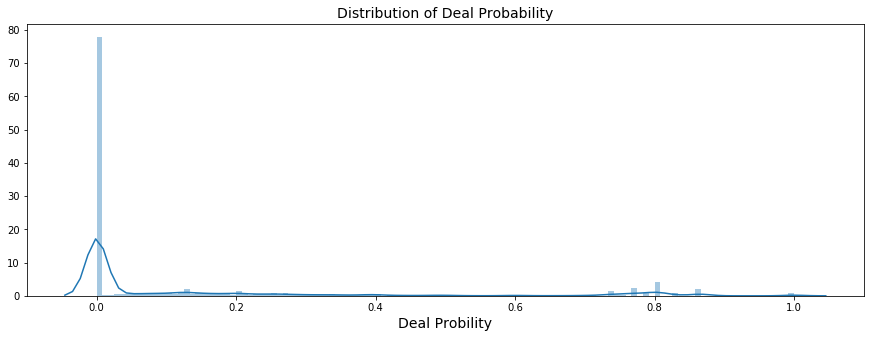

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(train_df["deal_probability"].values, bins=120)
plt.xlabel('Deal Probility', fontsize=14)
plt.title("Distribution of Deal Probability", fontsize=14)
plt.show()

**Result**  
1. From the deal probability distribution plot, it is clear that most of the items have exteremely low deal probability, about 78%, while very few values have the deal probability of 0.7 or larger.  
2. A very small tower is observed near the deal probability of 1.0, indicating that there are some items in the dataset having very high value of deal probability.  



In [17]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Region distribution',width=900,height=900)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

**The regions have percentage of ads between 1.71% to 9.41%. So the top regions are:**
1. Krasnodar region - 9.41%
2. Sverdlovsk region - 6.28%
3. Rostov region - 5.99%


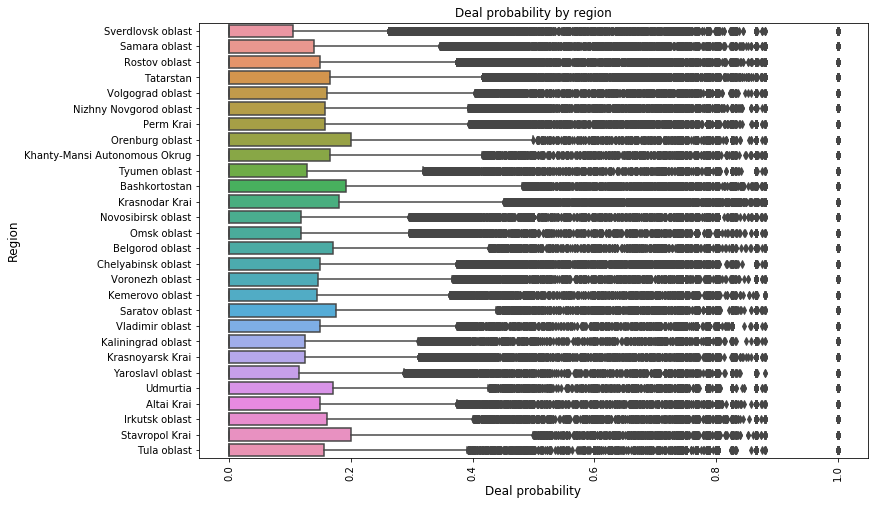

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

In [20]:
temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Parent Category distribution',width=900,height=900)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

46.4% of the ads are for Personal belongings, 11.9% are for home and garden and 11.5% for consumer electronics.

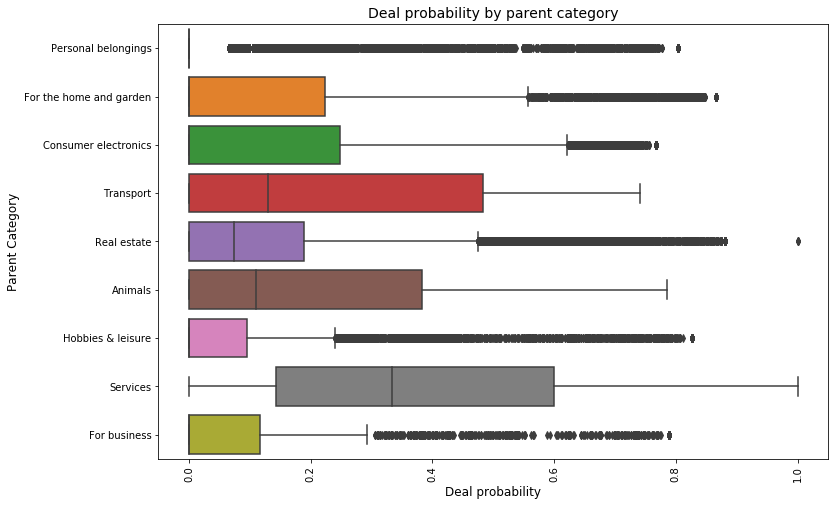

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(x="deal_probability",y="parent_category_name_en" , data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Services category seems to have slightly higher deal probability compared to others.

In [22]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='User Type distribution',width=600,height=600)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

Private users take about 72% of the data followed by company and shop.

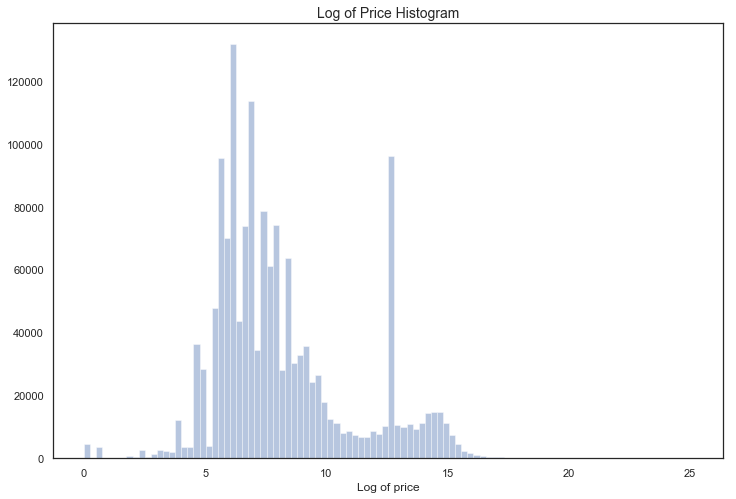

In [30]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

In [25]:
def _generate_bar_plot_ver(df, col, title, color, w=None, h=None, lm=0, limit=100, need_trace = False):
    cnt_srs = df[col].value_counts()[:limit]
    trace = go.Bar(x=list(cnt_srs.index), y=list(cnt_srs.values),
        marker=dict(color = color))
    if need_trace:
        return trace
    if w != None and h != None:
        layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    else:
        layout = dict(title=title, margin=dict(l=lm))
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
trace1 = _generate_bar_plot_ver(train_df, "title_len", "Title Length", '#f7a92c', 700, 400, 200, limit=30, need_trace = True)
trace2 = _generate_bar_plot_ver(train_df, "description_len", "Description Length", '#f7a92c', 700, 400, 200, limit=30, need_trace = True)

fig = tls.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Title Word Count','Description Word Count'])
fig.append_trace(trace1, 1, 1);
fig.append_trace(trace2, 1, 2);

fig['layout'].update(height=400, title='', showlegend=False);
py.iplot(fig); 

1. Items present in the dataset have a range of 1 to 10 words in the title, with title having 2 words in them have the highest number.
2. The length of description with range from 0 to 25 is most common. And a large number of items with no description are present in the dataset.
3. Items having description containing 6 words are highest.

In [26]:
import folium

cities = pd.read_csv('citynames.csv')
cities = cities.dropna()

map_osm = folium.Map(location=[63.5907183,97.4981968], zoom_start=3)

for i, row in cities.iterrows():
    folium.CircleMarker([row['Lat'], row['Long']],radius=row['size'],color=row['color'],fill_color=row['color']
                       ).add_to(map_osm)

map_osm

Visualizing the Cities on the Map. The size of circle is related to the ad frequency of each city.

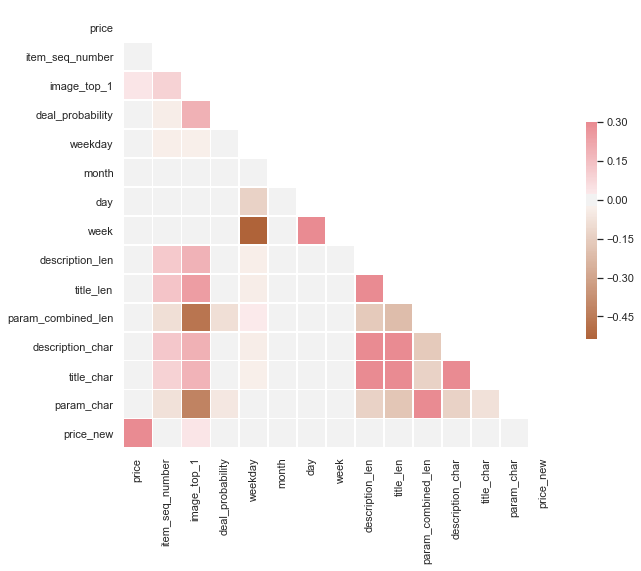

In [43]:
corr = train_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [45]:
corr['deal_probability']

price                -0.001097
item_seq_number      -0.035744
image_top_1           0.189979
deal_probability      1.000000
weekday               0.002096
month                 0.003555
day                  -0.002379
week                 -0.002861
description_len      -0.000968
title_len             0.016143
param_combined_len   -0.088814
description_char      0.002225
title_char            0.014537
param_char           -0.054996
price_new            -0.001057
Name: deal_probability, dtype: float64

1. From the correlation relationship, Deal probability shows good correlation with image_top_1 and title len. These may by important features while modelling.
2. Item Seq Number is also correlated mildly with title len, description len, and Image Top 1

In [28]:
cols = ['parent_category_name_en','deal_class_2']
colmap = sns.light_palette("#ff4284", as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]]).style.background_gradient(cmap = colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
parent_category_name_en,,,,,,,,,,
Animals,25379,5269,4511,7040,876,134,194,9067,0,0
Consumer electronics,111770,13321,9931,7681,1653,442,585,27625,0,0
For business,13325,1870,1078,119,115,120,53,1395,0,0
For the home and garden,118028,13115,9330,9063,1790,216,446,568,26267,0
Hobbies & leisure,64808,5436,3626,1868,660,143,193,243,9034,0
Personal belongings,579607,41554,21169,4110,1357,554,1073,787,47412,0
Real estate,89557,26407,15823,6078,4165,2095,1793,6258,1009,5
Services,15235,11190,5434,7592,4531,4347,408,5277,300,10071
Transport,37052,7982,5907,4479,4779,1077,837,17726,0,0


1. A large number of Consumer Electronics items have high deal probabiliy (0.7 - 0.8), Personal Belongings category which dominates the dataset also contains higher number of items having deal probability close to 1.0
2. Home and Garden related category also contains items having high deal probability.
3. Only services category has the items having deal probability greater than 0.9
4. After model filter can be built based on this.

In [46]:
cols = ['region_en','deal_class_2']
colmap = sns.light_palette("#7cc8ff", as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]]).style.background_gradient(cmap = colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
region_en,,,,,,,,,,
Altai Krai,29045,3720,2249,1386,400,187,140,1501,2724,168
Bashkortostan,45528,6350,4309,2715,1208,537,258,3595,3225,566
Belgorod oblast,19820,2414,1543,1139,467,214,115,1456,1428,272
Chelyabinsk oblast,55044,6411,3691,2228,1002,394,302,3891,4983,393
Irkutsk oblast,30078,4244,2731,1485,565,260,170,1708,2511,278
Kaliningrad oblast,24045,2362,1318,770,285,147,104,1204,2380,141
Kemerovo oblast,31443,3884,2296,1420,458,214,152,1821,2787,160
Khanty-Mansi Autonomous Okrug,19640,2647,1671,957,399,175,127,1254,1633,206
Krasnodar Krai,95227,13627,8146,5540,2434,1228,571,7205,5969,1469
